In [1]:
import os

# Use one GPU only
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=23400)])


from tensorflow.keras.models import load_model
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np
from os.path import isdir
from os import listdir

from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed

from numpy import load
from numpy import expand_dims
from numpy import asarray
import random

from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical


# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot


## Check graphics cards memory usage
!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Using TensorFlow backend.


Thu May 14 20:20:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:08:00.0 Off |                  N/A |
| 41%   31C    P8     4W / 280W |     12MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 207...  Off  | 00000000:43:00.0  On |                  N/A |
| 41%   32C    P3    23W / 215W |   6733MiB /  7974MiB |     34%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
# Pick our dataset
# dataset = 'data/Celeb1-A/10/'
dataset = 'data/Celeb1-A/1000/'

# Mean and std from training set
mean = 127.41816755496842
std =  63.643689073805

def extract_face(filename, detector, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)

    # detect faces in the image
    results = detector.detect_faces(pixels)
    if len(results) == 0:
        return None
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

## Introduction

This notebook loads a pre-trained facenet model using keras to do image recognition on a new dataset.
The dataset we will use is a 1000-person subset of the Celeb1-A dataset.

The remainder of this notebook is divided into the following sections.<br>

<b>Important:</b> Unless you wish to rerun the preprocessing and embedding steps, you can skip straight to the training step by loading in the provided "embeddings.npz" file.

* Preprocessing:
This step takes a given dataset and uses the mtcnn library to extract portions of an image that contains only the face.  This step produces the "faces.npz" file.<br><br>

* Embedding:
This step takes the preprocessed dataset and runs it through the pre-trained facenet model to generate a 128-dimensional vector representing the image.  We can conceptually think of this as taking a high dimensional image and hashing it into a low dimensional vector.  This step produces the "embeddings.npz" file.<br><br>

* Training:
This step creates a simple Sequential model with a 1000-class softmax output corresponding to the 1000 identities in our dataset and trains it on the training set.<br><br>

* Prediction:
This step inspects the results of the prediction on the validation set.<br><br>

## Preprocessing -- Extracting Faces

This step crops the images so that only the portion of the image containing the face is returned.
If no face is detected, return None.



In [3]:
# function for face detection with mtcnn


# MTCNN face detector is used to find the bounding box 
# of the face in the given image.
detector = MTCNN()

# Initialize model_enc to None.
# The model encoder is the pre-trained facenet model.
model_enc = None
 

In [4]:
# Given an image of a person, return only the portion of the image
# that is the face
def extract_face(filename, detector, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)

    # detect faces in the image
    results = detector.detect_faces(pixels)
    if len(results) == 0:
        return None
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path, detector)
        
        if face is not None:
            # store
            faces.append(face)
    return faces

# Load in training or validation set
# Directory is expected to be something like: "data/Celeb1-A/1000/train"
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    
    for subdir in listdir(directory):
        # path
        path = directory + '/' + subdir + '/'
        # skip any files that might be in the dir
        
        if not isdir(path):
            continue
        # load all faces in the subdirectory

        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


In [5]:
# Load train and validation test sets
trainX, trainy = load_dataset(dataset + '/train')
testX, testy = load_dataset(dataset + 'val')

>loaded 21 examples for class: 365
>loaded 8 examples for class: 785
>loaded 17 examples for class: 774
>loaded 11 examples for class: 159
>loaded 19 examples for class: 97
>loaded 16 examples for class: 718
>loaded 1 examples for class: 177
>loaded 18 examples for class: 580
>loaded 2 examples for class: 536
>loaded 19 examples for class: 557
>loaded 16 examples for class: 497
>loaded 11 examples for class: 245
>loaded 11 examples for class: 954
>loaded 10 examples for class: 299
>loaded 15 examples for class: 932
>loaded 21 examples for class: 147
>loaded 1 examples for class: 470
>loaded 12 examples for class: 836
>loaded 2 examples for class: 237
>loaded 18 examples for class: 133
>loaded 1 examples for class: 169
>loaded 19 examples for class: 49
>loaded 7 examples for class: 701
>loaded 18 examples for class: 491
>loaded 4 examples for class: 738
>loaded 3 examples for class: 791
>loaded 18 examples for class: 215
>loaded 21 examples for class: 21
>loaded 12 examples for class: 5

>loaded 12 examples for class: 591
>loaded 14 examples for class: 933
>loaded 16 examples for class: 229
>loaded 16 examples for class: 927
>loaded 14 examples for class: 938
>loaded 14 examples for class: 362
>loaded 16 examples for class: 195
>loaded 21 examples for class: 363
>loaded 21 examples for class: 14
>loaded 20 examples for class: 251
>loaded 13 examples for class: 29
>loaded 12 examples for class: 808
>loaded 2 examples for class: 566
>loaded 2 examples for class: 267
>loaded 20 examples for class: 55
>loaded 6 examples for class: 812
>loaded 18 examples for class: 459
>loaded 20 examples for class: 239
>loaded 19 examples for class: 113
>loaded 15 examples for class: 771
>loaded 9 examples for class: 695
>loaded 12 examples for class: 757
>loaded 16 examples for class: 106
>loaded 14 examples for class: 296
>loaded 18 examples for class: 521
>loaded 16 examples for class: 963
>loaded 14 examples for class: 90
>loaded 9 examples for class: 816
>loaded 14 examples for class

>loaded 11 examples for class: 443
>loaded 21 examples for class: 235
>loaded 21 examples for class: 334
>loaded 20 examples for class: 260
>loaded 16 examples for class: 77
>loaded 21 examples for class: 56
>loaded 14 examples for class: 533
>loaded 16 examples for class: 67
>loaded 20 examples for class: 104
>loaded 19 examples for class: 593
>loaded 21 examples for class: 38
>loaded 20 examples for class: 846
>loaded 14 examples for class: 197
>loaded 14 examples for class: 589
>loaded 20 examples for class: 146
>loaded 18 examples for class: 688
>loaded 19 examples for class: 923
>loaded 10 examples for class: 381
>loaded 14 examples for class: 903
>loaded 10 examples for class: 850
>loaded 16 examples for class: 607
>loaded 19 examples for class: 868
>loaded 20 examples for class: 476
>loaded 20 examples for class: 965
>loaded 17 examples for class: 12
>loaded 16 examples for class: 46
>loaded 17 examples for class: 258
>loaded 20 examples for class: 745
>loaded 20 examples for cl

>loaded 3 examples for class: 249
>loaded 21 examples for class: 487
>loaded 16 examples for class: 173
>loaded 14 examples for class: 408
>loaded 7 examples for class: 618
>loaded 8 examples for class: 201
>loaded 20 examples for class: 594
>loaded 3 examples for class: 996
>loaded 20 examples for class: 445
>loaded 17 examples for class: 750
>loaded 9 examples for class: 664
>loaded 6 examples for class: 472
>loaded 7 examples for class: 998
>loaded 18 examples for class: 576
>loaded 14 examples for class: 852
>loaded 14 examples for class: 875
>loaded 13 examples for class: 211
>loaded 11 examples for class: 778
>loaded 21 examples for class: 17
>loaded 21 examples for class: 248
>loaded 5 examples for class: 479
>loaded 20 examples for class: 121
>loaded 20 examples for class: 386
>loaded 1 examples for class: 917
>loaded 21 examples for class: 192
>loaded 12 examples for class: 911
>loaded 21 examples for class: 844
>loaded 13 examples for class: 60
>loaded 16 examples for class: 

>loaded 8 examples for class: 309
>loaded 13 examples for class: 880
>loaded 21 examples for class: 433
>loaded 7 examples for class: 254
>loaded 11 examples for class: 354
>loaded 13 examples for class: 568
>loaded 9 examples for class: 602
>loaded 18 examples for class: 140
>loaded 14 examples for class: 326
>loaded 18 examples for class: 858
>loaded 17 examples for class: 780
>loaded 10 examples for class: 504
>loaded 18 examples for class: 27
>loaded 18 examples for class: 240
>loaded 17 examples for class: 839
>loaded 3 examples for class: 616
>loaded 21 examples for class: 66
>loaded 19 examples for class: 130
>loaded 17 examples for class: 960
>loaded 15 examples for class: 705
>loaded 20 examples for class: 608
>loaded 14 examples for class: 164
>loaded 20 examples for class: 126
>loaded 13 examples for class: 560
>loaded 12 examples for class: 30
>loaded 5 examples for class: 529
>loaded 11 examples for class: 752
>loaded 15 examples for class: 714
>loaded 17 examples for clas

>loaded 9 examples for class: 468
>loaded 6 examples for class: 921
>loaded 8 examples for class: 167
>loaded 8 examples for class: 898
>loaded 6 examples for class: 789
>loaded 8 examples for class: 500
>loaded 1 examples for class: 111
>loaded 7 examples for class: 53
>loaded 1 examples for class: 478
>loaded 8 examples for class: 530
>loaded 1 examples for class: 223
>loaded 3 examples for class: 2
>loaded 6 examples for class: 399
>loaded 6 examples for class: 493
>loaded 9 examples for class: 731
>loaded 7 examples for class: 428
>loaded 9 examples for class: 403
>loaded 7 examples for class: 786
>loaded 5 examples for class: 682
>loaded 7 examples for class: 452
>loaded 9 examples for class: 47
>loaded 7 examples for class: 88
>loaded 8 examples for class: 596
>loaded 9 examples for class: 343
>loaded 8 examples for class: 137
>loaded 8 examples for class: 644
>loaded 7 examples for class: 509
>loaded 9 examples for class: 439
>loaded 2 examples for class: 712
>loaded 9 examples 

>loaded 7 examples for class: 760
>loaded 9 examples for class: 826
>loaded 7 examples for class: 964
>loaded 9 examples for class: 230
>loaded 6 examples for class: 392
>loaded 9 examples for class: 209
>loaded 6 examples for class: 628
>loaded 9 examples for class: 873
>loaded 6 examples for class: 790
>loaded 5 examples for class: 937
>loaded 9 examples for class: 988
>loaded 7 examples for class: 414
>loaded 3 examples for class: 546
>loaded 6 examples for class: 552
>loaded 9 examples for class: 85
>loaded 4 examples for class: 543
>loaded 5 examples for class: 976
>loaded 3 examples for class: 601
>loaded 7 examples for class: 151
>loaded 3 examples for class: 161
>loaded 9 examples for class: 448
>loaded 7 examples for class: 934
>loaded 9 examples for class: 397
>loaded 5 examples for class: 150
>loaded 3 examples for class: 355
>loaded 7 examples for class: 857
>loaded 9 examples for class: 993
>loaded 2 examples for class: 717
>loaded 6 examples for class: 18
>loaded 6 exampl

>loaded 9 examples for class: 371
>loaded 9 examples for class: 409
>loaded 7 examples for class: 232
>loaded 7 examples for class: 734
>loaded 7 examples for class: 959
>loaded 1 examples for class: 673
>loaded 1 examples for class: 74
>loaded 5 examples for class: 538
>loaded 9 examples for class: 291
>loaded 9 examples for class: 78
>loaded 6 examples for class: 396
>loaded 9 examples for class: 677
>loaded 8 examples for class: 331
>loaded 1 examples for class: 522
>loaded 9 examples for class: 284
>loaded 5 examples for class: 241
>loaded 9 examples for class: 999
>loaded 6 examples for class: 559
>loaded 7 examples for class: 586
>loaded 5 examples for class: 905
>loaded 7 examples for class: 473
>loaded 9 examples for class: 64
>loaded 1 examples for class: 244
>loaded 3 examples for class: 729
>loaded 6 examples for class: 294
>loaded 3 examples for class: 891
>loaded 5 examples for class: 182
>loaded 9 examples for class: 944
>loaded 9 examples for class: 351
>loaded 3 example

>loaded 7 examples for class: 224
>loaded 9 examples for class: 464
>loaded 6 examples for class: 506
>loaded 7 examples for class: 115
>loaded 9 examples for class: 971
>loaded 6 examples for class: 970
>loaded 9 examples for class: 508
>loaded 9 examples for class: 651
>loaded 3 examples for class: 662
>loaded 9 examples for class: 515
>loaded 5 examples for class: 293
>loaded 9 examples for class: 562
>loaded 1 examples for class: 636
>loaded 6 examples for class: 507
>loaded 7 examples for class: 216
>loaded 7 examples for class: 799
>loaded 8 examples for class: 39
>loaded 7 examples for class: 465
>loaded 7 examples for class: 269
>loaded 1 examples for class: 902
>loaded 2 examples for class: 300
>loaded 8 examples for class: 385
>loaded 9 examples for class: 301
>loaded 4 examples for class: 989
>loaded 9 examples for class: 384
>loaded 9 examples for class: 919
>loaded 6 examples for class: 217
>loaded 8 examples for class: 939
>loaded 9 examples for class: 69
>loaded 9 exampl

In [6]:
print(len(np.unique(testy)))
print(len(np.unique(trainy)))

1000
1000


In [7]:
# This file can be pretty large since it is essentially a numpy array with
# simple compression.  May or may not need 
savez_compressed(dataset + '/faces.npz', trainX, trainy, testX, testy)

## Create Face Embeddings

In [8]:
# load the face dataset
data = load(dataset + 'faces.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model_enc = load_model('facenet_keras.h5')
print('Loaded Model')


Loaded:  (14406, 160, 160, 3) (14406,) (6722, 160, 160, 3) (6722,)
Loaded Model


In [9]:
# get the face embedding for one face
def get_embedding(model, samples):
    # scale pixel values
    samples = samples.astype('float32')
    
    #print(samples.shape)
    # standardize pixel values across channels (global)
    
    #mean, std = samples.mean(), samples.std()
    #samples = (samples - mean)/std
    
    #print(std.shape)
    #face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    #samples = expand_dims(face_pixels, axis=0)
    #print(samples.shape)
    # make prediction to get embedding
    
    yhat = model.predict(samples)
    return yhat


In [10]:
# Another preprocessing step, we do this here instead so that
# faces.npz contains the original image and we can display the original image if needed

# Normalize data using mean and std from trainX
mean = trainX.mean()
std = trainX.std()

print("mean:", mean)
print("std: ", std)

trainX = (trainX - mean) / std
testX = (testX - mean) / std

mean: 127.41816755496842
std:  63.643689073805


In [11]:
# convert each face in the train set to an embedding
trainX = get_embedding(model_enc, trainX)
testX = get_embedding(model_enc, testX)

savez_compressed(dataset + 'embeddings.npz', trainX, trainy, testX, testy)

In [12]:
trainX.shape

(14406, 128)

In [13]:
testX.shape

(6722, 128)

## Training Softmax Classifier

This step reads in the embeddings and labels for the training set and trains a softmax classifier to recognize the identity of the person given the 128-dimensional embedding vector.

In [14]:
data = load(dataset + '/embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
trainy = trainy.astype(np.uint32)
testy = testy.astype(np.uint32)

#out_encoder = LabelEncoder()
#out_encoder.fit(trainy)
#trainy = out_encoder.transform(trainy)
#testy = out_encoder.transform(testy)

In [15]:
# The directories we have are labeled from 1-1000
# subtract one so that 
trainy = trainy - 1
testy = testy - 1

In [16]:
num_classes = len(np.unique(trainy))
num_classes

1000

In [17]:
trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [18]:
trainy.shape

(14406, 1000)

In [23]:
# Model for softmax classification
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras import layers

model = Sequential()
model.add(Input(shape=(128,)))
#model.add(layers.Dense(250, kernel_regularizer='l2'))
#model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(num_classes, activation="softmax"))


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              129000    
Total params: 129,000
Trainable params: 129,000
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Set optimizer, loss function, and metrics
opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['acc'])

In [26]:
# Train!
history = model.fit(trainX, trainy, validation_data=(testX, testy), batch_size=64, epochs=15)

Train on 14406 samples, validate on 6722 samples
Epoch 1/15
14406/14406 [==============================] - 1s 61us/sample - loss: 5.3321 - acc: 0.4018 - val_loss: 3.6376 - val_acc: 0.7920
Epoch 2/15
14406/14406 [==============================] - 1s 47us/sample - loss: 2.4824 - acc: 0.8597 - val_loss: 1.7176 - val_acc: 0.8841
Epoch 3/15
14406/14406 [==============================] - 1s 48us/sample - loss: 1.1621 - acc: 0.9207 - val_loss: 1.0345 - val_acc: 0.9130
Epoch 4/15
14406/14406 [==============================] - 1s 46us/sample - loss: 0.6965 - acc: 0.9421 - val_loss: 0.7699 - val_acc: 0.9255
Epoch 5/15
14406/14406 [==============================] - 1s 47us/sample - loss: 0.4955 - acc: 0.9539 - val_loss: 0.6447 - val_acc: 0.9277
Epoch 6/15
14406/14406 [==============================] - 1s 47us/sample - loss: 0.3858 - acc: 0.9611 - val_loss: 0.5745 - val_acc: 0.9322
Epoch 7/15
14406/14406 [==============================] - 1s 48us/sample - loss: 0.3159 - acc: 0.9666 - val_loss: 0.5

## Prediction

This part of the notebook lets us inspect how well our classifier is doing by running the softmax classifier on the validation set and displaying the image + filename, and prediction along with the prediction confidence.

In [27]:
# Load the facenet model in case it hasn't been loaded yet
if model_enc is None:
    model_enc = load_model('facenet_keras.h5')

In [28]:
def predict_image(filename, model_enc, model_dec, plot=True):
    # load image in, extract face pixels, get embedding
    face_pixels = extract_face(filename, detector)
    
    
    if face_pixels is None:
        return -1
    
    image_x = np.asarray(face_pixels)
    
    if plot:
        pyplot.imshow(face_pixels)

        pyplot.title(filename)
        pyplot.show()
    #print("image shape", image_x.shape)
   
    face_pixels = (face_pixels - mean)/std
    face_pixels = expand_dims(face_pixels, axis=0)
    

    image_emb = get_embedding(model_enc, face_pixels)
    
    yhat = model_dec.predict(image_emb)
    
    # get_name 
    class_index = np.argmax(yhat[0])
    
    # Add one to match up with the directory names
    
    
    class_probability = yhat[0,class_index] * 100
    
    class_index = class_index+1
    #predict_names = out_encoder.inverse_transform(yhat_class)
    print('Predicted: %s (%.3f)' % (class_index, class_probability))
    #print('Expected: %s' % random_face_name[0])
    # plot for fun
    

    return class_index

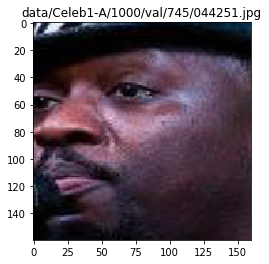

Predicted: 745 (50.994)
Correct!


In [35]:
path = 'data/Celeb1-A/1000/val/'
random_id = random.randint(1, 1000)

path = path  + str(random_id)


images = os.listdir(path)
random_image = random.choice(images)

filename = path + '/' + random_image

class_index = predict_image(filename, model_enc, model)

if class_index == random_id:
    print("Correct!")
else:
    print("Wrong!")



In [ ]:
## Run prediction on 1000 randomly selected images from our dataset
## and see how well it does

total = 1000
correct = 0

for i in range(total):
    path = 'data/Celeb1-A/1000/val/'
    random_id = random.randint(1, 1000)

    path = path  + str(random_id)


    images = os.listdir(path)
    random_image = random.choice(images)

    filename = path + '/' + random_image

    class_index = predict_image(filename, model_enc, model, plot=False)

    if class_index == random_id:
        correct += 1
    
print("Accuracy: ", correct/total*100.)

Predicted: 144 (98.320)
Predicted: 916 (16.977)
Predicted: 857 (99.127)
Predicted: 788 (98.282)
Predicted: 841 (9.863)
Predicted: 348 (98.828)
Predicted: 395 (76.048)
Predicted: 184 (98.185)
Predicted: 643 (16.213)
Predicted: 923 (98.742)
Predicted: 965 (99.597)
Predicted: 876 (95.278)
Predicted: 670 (53.591)
Predicted: 644 (98.171)
Predicted: 651 (97.275)
Predicted: 675 (97.025)
Predicted: 563 (99.296)
Predicted: 895 (95.603)
Predicted: 840 (97.185)
Predicted: 683 (87.696)
Predicted: 331 (98.420)
Predicted: 677 (83.797)
Predicted: 69 (98.607)
Predicted: 921 (98.767)
Predicted: 160 (96.836)
Predicted: 764 (98.610)
Predicted: 83 (59.508)
Predicted: 720 (89.893)
Predicted: 144 (98.320)
Predicted: 350 (78.473)
Predicted: 332 (98.327)
Predicted: 564 (97.087)
Predicted: 264 (90.250)
Predicted: 422 (99.306)
Predicted: 523 (96.812)
Predicted: 711 (90.289)
Predicted: 949 (94.927)
Predicted: 18 (91.957)
Predicted: 822 (99.393)
Predicted: 787 (65.428)
Predicted: 447 (99.547)
Predicted: 771 (96.1

Predicted: 627 (10.655)
Predicted: 121 (99.498)
Predicted: 332 (95.926)
Predicted: 691 (99.124)
Predicted: 561 (79.464)
Predicted: 92 (68.447)
Predicted: 37 (15.075)
Predicted: 739 (93.024)
Predicted: 16 (96.179)
Predicted: 273 (92.902)
Predicted: 418 (85.842)
Predicted: 267 (94.521)
Predicted: 438 (94.892)
